In [ ]:
%pip install pandarallel tsfresh -q

In [1]:
# Other tools
import random
import os
import gc
from collections import Counter

from tqdm import tqdm
#pandarallel for parallezation
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# Train
from sklearn.impute import SimpleImputer
import sklearn

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import pandas as pd
import numpy as np

# Model
import lightgbm as lgb
import xgboost as xgb

from catboost import Pool
#local imports
from utils import set_seed_no_torch, reduce_mem_usage, find_cat_features, cpu_usage

import warnings
import pickle
import math
import geopandas as gpd
from sklearn.decomposition import PCA

# feature generation
# import spacy

#ts based features
# from tsfresh.utilities.dataframe_functions import roll_time_series
# from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
# from tsfresh import extract_features

# some settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18

plt.rcParams['savefig.format'] = 'pdf'

warnings.filterwarnings('ignore')

C:\Users\Mi\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
SEED = 11
set_seed_no_torch(SEED)

### Reading data

In [ ]:
# import pyarrow.parquet as pq

#loading with chunks
# parquet_file = pq.ParquetFile('example.parquet')

# for batch in parquet_file.iter_batches():
#     batch_df = batch.to_pandas()

# chunksize = 10e9
# sep = ','
# train = pd.read_csv("../shared/Rutube_v2.0/train.parquet", chunksize=chunksize, sep=sep)
# test = pd.read_csv("../shared/Rutube_v2.0/test.parquet", chunksize=chunksize, sep=sep)
# videos = pd.read_csv("../shared/Rutube_v2.0/video_stat.parquet", chunksize=chunksize, sep=sep)

# train = pd.read_parquet("../shared/Rutube_v2.0/train.parquet")
# test = pd.read_parquet("../shared/Rutube_v2.0/test.parquet")
# videos = pd.read_parquet("../shared/Rutube_v2.0/video_stat.parquet")

### working with nas

In [3]:
def fillnas(train, cols2check, cat_features, test=None):
    for col in cols2check:
      if col not in cat_features:
        imp = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
        train[col] = imp.transform(train[col].values.reshape(-1, 1))
        if test is not None:
            test[col] = imp.transform(test[col].values.reshape(-1, 1))
      else:
        # val = statistics.mode(train[col].values)
        val = -1
        train[col].fillna(val, inplace=True)
        if train[col] is not None:
            test[col].fillna(val, inplace=True)
    return train, test

### date and geo features

In [4]:
def generate_date_features(df, date_cols):

  for date_col in date_cols:

      df[date_col] = pd.to_datetime(df[date_col])
    
      # Извлечение базовых признаков
      df[f'{date_col}_year'] = df[date_col].dt.year
      df[f'{date_col}_month'] = df[date_col].dt.month
      df[f'{date_col}_day'] = df[date_col].dt.day
      df[f'{date_col}_day_of_week'] = df[date_col].dt.dayofweek
      df[f'{date_col}_hour'] = df[date_col].dt.hour
      df[f'{date_col}_hour_weekofyear'] = df[date_col].apply(lambda x : x.weekofyear)
      df[f'{date_col}_week_hour'] = df[f'{date_col}_day_of_week'] * 24 + df[f'{date_col}_hour']

    
      # Бинарные признаки
      df[f'{date_col}_is_weekend'] = df[f'{date_col}_day_of_week'].isin([5, 6]).astype(int)  # Суббота и воскресенье
      # df['is_holiday'] = df['timestamp'].dt.strftime('%m-%d').isin(['01-01', '07-04', '12-25']).astype(int)  # Пример праздников
    
      # Циклические признаки
      df[f'{date_col}_hour_sin'] = np.sin(2 * np.pi * df[f'{date_col}_hour'] / 24)
      df[f'{date_col}_hour_cos'] = np.cos(2 * np.pi * df[f'{date_col}_hour'] / 24)
      df[f'{date_col}_month_sin'] = np.sin(2 * np.pi * df[f'{date_col}_month'] / 12)
      df[f'{date_col}_month_cos'] = np.cos(2 * np.pi * df[f'{date_col}_month'] / 12)
      df[date_col] = df[date_col].apply(lambda x: x.timestamp())
    
  return df

def generate_geo_features(df, pois):
  #cities - https://github.com/epogrebnyak/ru-cities/blob/main/assets/towns.csv
  from sklearn.cluster import KMeans, DBSCAN
  from geopy.distance import geodesic 

  for poi in pois:
    df[f'distance_to_{poi["name"]}'] = df.parallel_apply(lambda row: geodesic((row['latitude'], row['longitude']), poi['coords']).km, axis=1)
  
  kmeans = KMeans(n_clusters=10)
  df['geo_cluster_kmeans'] = kmeans.fit_predict(df[['latitude', 'longitude']])
  # df['geo_cluster_dbscan'] = DBSCAN(min_samples=2).fit_predict(df[['latitude', 'longitude']])

  # Признаки синус-косинус для направления
  df['lat_sin'] = np.sin(np.radians(df['latitude']))
  df['lat_cos'] = np.cos(np.radians(df['latitude']))
  df['lon_sin'] = np.sin(np.radians(df['longitude']))
  df['lon_cos'] = np.cos(np.radians(df['longitude']))

  df['lan_lon'] = df['latitude'] / df['longitude']
  df['lon_lat'] = df['longitude'] / df['latitude']

  df['lat_rad'] = df['latitude'].apply(lambda x: math.radians(x))
  df['lon_rad'] = df['longitude'].apply(lambda x: math.radians(x))

  return df

def base_coords_cleanup(df):
    return df[
        (df['latitude'] >= -90) & \
        (df['latitude'] <= 90) & \
        (df['longitude'] >= -180) & \
        (df['longitude'] <= 180) & \
        (df['longitude'] != 0) & \
        (df['latitude'] != 0)
    ]

In [5]:
def visualize(data):
  '''
  input: dataframe containing Latitude(x) and Longitude(y)
  '''
  data[['x','y']].scatter(color='blue', s=1, alpha=0.1)
  plt.title('Visualization of Latitude and Longitude')
  plt.ylabel('latitude')
  plt.xlabel('longitude')
  plt.show()

In [7]:
#generate geo features
# pois = {'name' : 'moscow_center', 'coords' : (55.751244, 37.618423)}
# train = generate_geo_features(train, pois).
# test = generate_geo_features(test, pois)

#### PCA

In [5]:
def pca_(df):

    pca = PCA().fit(df[['latitude', 'longitude']].values)
    df['pca0'] = pca.transform(df[['latitude', 'longitude']])[:, 0]
    df['pca1'] = pca.transform(df[['latitude', 'longitude']])[:, 1]

    return df

def visualize(data):
  '''
  input: dataframe containing Latitude(x) and Longitude(y)
  '''
  sns.scatterplot(x=data['longitude'], y=data['latitude'], color='blue')
  plt.title('Visualization of Latitude and Longitude')
  plt.ylabel('latitude')
  plt.xlabel('longitude')
  plt.show()

#### Distances

In [6]:
from geopy.distance import geodesic

def find_nearest_k(geometry, tr_gdf, tt_gdf, k):
    distances_tr = tr_gdf.geometry.distance(geometry)
    distances_tt = tt_gdf.geometry.distance(geometry)
    # nearest_index = distances[distances.values != 0].idxmin()
    # nearest = gdf.loc[nearest_index, 'geometry']
    # return geodesic((geometry.x, geometry.y), (nearest.x, nearest.y)).km
    return (distances_tr[distances_tr.values != 0].sort_values()[:k].mean() + \
        distances_tt[distances_tt.values != 0].sort_values()[:k].mean()) / 2


def find_nearest(geometry, tr_gdf, tt_gdf):
    distances_tr = tr_gdf.geometry.distance(geometry)
    distances_tt = tt_gdf.geometry.distance(geometry)
    # nearest_index = distances[distances.values != 0].idxmin()
    # nearest = gdf.loc[nearest_index, 'geometry']
    # return geodesic((geometry.x, geometry.y), (nearest.x, nearest.y)).km
    return min(
        distances_tr[distances_tr.values != 0].min(),
        distances_tt[distances_tt.values != 0].min(),
    )

#### Densities

In [7]:
def compute_densities(gpd1, gpd2):

    # gpd1 = gpd1.to_crs('EPSG:32633')
    # gpd2 = gpd2.to_crs('EPSG:32633')
    gpd1['buffer'] = gpd1.geometry.buffer(10)
    gpd1['count'] = gpd1.apply(
        lambda row: gpd1.intersects(row.buffer).sum() + \
        gpd2.intersects(row.buffer).sum()
    , axis=1)
    print(gpd1['count'])
    return gpd1['count'] / 1  # заменить константу

#### Grid

In [8]:
def get_grid(gdf):
  grid_size = 100  # Определение размера сетки
  # gdf['grid_x'] = (gdf.geometry.x // grid_size).astype(int)
  # gdf['grid_y'] = (gdf.geometry.y // grid_size).astype(int)
  
  R = 6371  # Радиус Земли в км
  gdf['x_sphere'] = R * np.radians(gdf.geometry.x) * np.cos(np.radians(gdf.geometry.y))
  gdf['y_sphere'] = R * np.radians(gdf.geometry.y)
  return gdf['grid_x'], gdf['grid_y'], gdf['x_sphere'], gdf['y_sphere']

### Grid and Bin


In [9]:
def get_grid_v2(df):
    grid = {}
    c = 0
    for i in range(100):
        for j in range(100):
            grid[(i, j)] = c
            c += 1

    def grid_x(x):
        return  grid.get((x.lon_bin, x.lat_bin), -1)
    
    if str(df['latitude'].dtype) != 'float64':
        df['latitude'] = df['latitude'].astype(np.float64)

    if str(df['longitude'].dtype) != 'float64':
        df['longitude'] = df['longitude'].astype(np.float64)

    df['lat_bin'] = pd.cut(df['latitude'], np.linspace(df['latitude'].min(), df['latitude'].max(), 100), labels=np.arange(100 - 1)).cat.add_categories([-1]).fillna(-1).astype(int)
    df['lon_bin'] = pd.cut(df['longitude'], np.linspace(df['longitude'].min(), df['longitude'].max(), 100), labels=np.arange(100 - 1)).cat.add_categories([-1]).fillna(-1).astype(int)
    df['grid_bin'] = df.apply(grid_x, axis=1)
    return df

In [10]:
def create_grid(feature, shape, side_length, proj):
    from shapely import Polygon, box
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))


    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in tqdm(np.arange(min_x, max_x + x_step, x_step)):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in tqdm(np.arange(min_y, max_y + y_step, y_step)):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = proj)

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

In [11]:
# def add_extra_manh_features(df):
#     df['Euclidean'] = (df.abs_diff_latitude**2 + df.abs_diff_longitude**2)**0.5 ### as the crow flies  
#     df['delta_manh_long'] = (df.Euclidean*np.sin(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
#     df['delta_manh_lat'] = (df.Euclidean*np.cos(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
#     df['manh_length'] = df.delta_manh_long + df.delta_manh_lat
#     df['Euc_error'] = (df['manh_length'] - df['Euclidean'])*100 /  df['Euclidean']

# add_extra_manh_features(train_df)

# gby_cols = ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
#                'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']

# mean_cols = ['avg_speed_h', 'avg_speed_m', 'log_trip_duration']

# for gby_col in gby_cols:
#     gby = train.groupby(gby_col)[mean_cols].mean()
#     gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
#     train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
#     test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

#### metro and city features

In [105]:
from functools import partial

def find_nearest_features(point, gstations=None):
    point_geo = point.geometry
    distances = gstations.geometry.distance(point_geo)
    ind = distances.idxmin()
    point['nearest_metro_distance'] = distances[ind]
    # point['city_name'] = gstations.loc[ind, 'city']
    point['nearest_metro_name'] = gstations.loc[ind, 'name']
    return point

In [13]:
pd 

<module 'pandas' from 'C:\\Users\\Mi\\AppData\\Roaming\\Python\\Python311\\site-packages\\pandas\\__init__.py'>

In [125]:
pd.cut([1, 2, 3, 4], np.linspace(0, 5, 100), labels=np.arange(99)).fillna(0).astype(int)

array([19, 39, 59, 79])

### Text features

In [13]:
def generate_text_features(df, text_columns):

    def count_mean_length(x):
        words_lens = [len(w) for w in x.split(" ")]
        return sum(words_lens) / len(words_lens)
    
    for text_col in text_columns:

        df[f'{text_col}_num_letters'] = df[f'{text_col}'].parallel_apply(lambda x: len(x))
        df[f'{text_col}_num_words'] = df[f'{text_col}'].parallel_apply(lambda x: len(x.split(" ")))
        df[f'{text_col}_mean_word_length'] = df[f'{text_col}'].parallel_apply(count_mean_length)

    return df

In [ ]:
# videos = generate_text_features(videos, ['title', 'description'])

### Ts features

In [14]:
#ts features
def extract_ts_features(df, target_columns, time_col, id_col, window_size=None, param_type="min"):
    # params EfficientFCParameters works for feature count <= 5
    # params MinimalFCParameters works for every feature count

    target_df = df.loc[:, target_columns + [id_col, time_col]]

    del df
    gc.collect()

    extracted_df_features = extract_features(
        target_df,
        column_id=id_col,
        column_sort=time_col,
        n_jobs=6,
        default_fc_parameters=(MinimalFCParameters() if param_type=="min" else EfficientFCParameters())
    )

    return extracted_df_features

# Sort the data
def add_shifted_features(df, sort_index, id_col, target_columns=[], lags=[1]):

  df = df.sort_values(by=sort_index).reset_index(drop=True)

  def add_lagged_features(group, lags, target_column):
      for lag in lags:
          group[f'{target_column}_lag_{lag}'] = group[target_column].shift(lag)
      return group

  new_features = []

  for target_column in tqdm(target_columns):

    grouped_data_df = df.groupby(id_col)[target_columns].apply(
        add_lagged_features,
        lags=lags,
        target_column=target_column
      )

    new_features_target_col = [f'{target_column}_lag_{lag}' for lag in lags]

    df.loc[:, new_features_target_col] = df[new_features_target_col]

    new_features.extend(new_features_target_col)

  return df, new_features

def applyftt(df, timestamp_column, target_column, plot=False):
  
    df = df.copy()
    
    df.sort_values(by=timestamp_column, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    time = df[timestamp_column].values
    timestep = np.mean(np.diff(time))
    numeric_columns = df.select_dtypes(include=[np.number]).columns.drop([timestamp_column, target_column])
    
    def fft_transform(signal, timestep, plot_title=None):
        n = len(signal)
        fft_result = np.fft.fft(signal)
        freq = np.fft.fftfreq(n, d=timestep)
        amplitude = np.abs(fft_result)
        
        positive_freq = freq > 0
        freq = freq[positive_freq]
        amplitude = amplitude[positive_freq]
        
        return freq, amplitude

    target_signal = df[target_column].values
    freq, amplitude = fft_transform(target_signal, timestep, plot_title=target_column)

    top_frequencies = freq[np.argsort(-amplitude)[:3]]
    for i, f in enumerate(top_frequencies):
        df[f'sin_freq_{i+1}'] = np.sin(2 * np.pi * f * df[timestamp_column])
        df[f'cos_freq_{i+1}'] = np.cos(2 * np.pi * f * df[timestamp_column])
    
    for col in numeric_columns:
        signal = df[col].values
        _, amplitude = fft_transform(signal, timestep, plot_title=col)
        df[f'{col}_max_fft_amp'] = amplitude.max()
    
    return df


In [ ]:
# train_feats = extract_ts_features(train, target_columns=list(videos.columns[2:12]), id_col='user_id', time_col='event_timestamp')
# test_feats = extract_ts_features(test, target_columns=list(videos.columns[2:12]), id_col='user_id', time_col='event_timestamp')
# train_feats = add_shifted_features(train, sort_index=['event_timestamp'], target_columns=list(videos.columns[2:3]), id_col='user_id')
# test_feats = add_shifted_features(test, sort_index=['event_timestamp'], target_columns=list(videos.columns[2:3]), id_col='user_id')

### Sampling smaller dataset

In [16]:
def sample_small_dataset(df, target, id_col, coefs_ = [1, 0.2]):
  unique_pos = df[df[target] == 1][id_col].unique()
  unique_neg = df[df[target] == 0][id_col].unique()

  # set_seed_no_torch(SEED)
  left_unique_pos = np.random.choice(unique_pos, size=int(len(unique_pos) * coefs_[0]), replace=False)
  # set_seed_no_torch(SEED)
  left_unique_neg = np.random.choice(unique_neg, size=int(len(unique_neg) * coefs_[1]), replace=False)

  del unique_pos,  unique_neg
  gc.collect()

  sampled_df = df[df[id_col].isin(
      list(left_unique_pos) + list(left_unique_neg)
  )]

  return sampled_df

In [25]:
train = sample_small_dataset(train, 'watchtime', 'user_id', coefs_=[1, 0.15])

In [ ]:
cpu_usage()

### Functions for all features 

In [15]:
def generate_minimal_date_geo_features_v2(
        df,
        df2,
        date_cols, 
        pois,
        features2drop,
        text_features=[],
    ):
    
    #includes dates and some geo features
    df.drop(columns=features2drop, inplace=True)
    print('+Features dropped')

    df = generate_date_features(df, date_cols)
    print('+Times features generated')

    df = generate_geo_features(df, pois)
    print('+Base geo features generated')

    df = pca_(df.fillna(0))
    print('+Pca complited')

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:32633')
    gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude), crs='EPSG:32633')

    #mean k nearest neighbors distances for train 
    # df['k_nearest_distance'] = gdf.geometry.apply(lambda geom: find_nearest_k(
    #     geom, 
    #     gdf,
    #     gdf2,
    #     3
    # ))

    # df['nearest_distance'] = gdf.geometry.apply(lambda geom: find_nearest(
    #     geom, 
    #     gdf,
    #     gdf2
    # ))

    # print('+Distance features generated')

    # df['density'] = compute_densities(gdf, gdf2)
    # print('+Density features')

    df['grid_x'], df['grid_y'], df['x_sphere'], df['y_sphere'] = \
        get_grid(gdf)
    
    df = get_grid_v2(df)
    print('Grid features generated')
    
    if len(text_features) != 0:
        df = generate_text_features(df, text_features)
    
    return df

In [16]:
def generate_minimal_date_geo_features(
        df,
        df2,
        date_cols, 
        pois,
        features2drop,
    ):
    
    #includes dates and some geo features
    df.drop(columns=features2drop, inplace=True)
    print('+Features dropped')

    df = generate_date_features(df, date_cols)
    print('+Times features generated')

    df = generate_geo_features(df, pois)
    print('+Base geo features generated')

    df = pca_(df.fillna(0))
    print('+Pca complited')

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326').to_crs(epsg=3857)
    gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude), crs='EPSG:4326').to_crs(epsg=3857)

    #mean k nearest neighbors distances for train 
    # df['k_nearest_distance'] = gdf.geometry.apply(lambda geom: find_nearest_k(
    #     geom, 
    #     gdf,
    #     gdf2,
    #     3
    # ))

    # df['nearest_distance'] = gdf.geometry.apply(lambda geom: find_nearest(
    #     geom, 
    #     gdf,
    #     gdf2
    # ))

    print('+Distance features generated')

    return df

### generating features

In [17]:
df_train = pd.read_csv('train.csv/train.csv', chunksize=1e6)
all_coords_test = pd.read_csv('test (1).csv', usecols=['pickup_latitude', 'pickup_longitude']).rename({'pickup_latitude': 'latitude', 'pickup_longitude' : 'longitude'}, axis=1)

In [18]:
all_coords_train = pd.read_csv('train.csv/train.csv', usecols=['pickup_latitude', 'pickup_longitude'], engine='pyarrow').rename({'pickup_latitude': 'latitude', 'pickup_longitude' : 'longitude'}, axis=1)

In [19]:
make_grid = False
if make_grid:
    gdf_test = gpd.GeoDataFrame(
        all_coords_test, 
        geometry=gpd.points_from_xy(
            all_coords_test.longitude,
            all_coords_test.latitude
        ), 
        crs='EPSG:4326'
    ).to_crs(epsg=3857)
    gdf_train = gpd.GeoDataFrame(
        all_coords_train, 
        geometry=gpd.points_from_xy(
            all_coords_train.longitude, 
            all_coords_train.latitude
        ), 
        crs='EPSG:4326'
    ).to_crs(epsg=3857)

In [23]:
if make_grid:
    precomputed_grid = create_grid(
        gdf_train.geometry,
        shape='hexagon',
        side_length=100,
        proj='EPSG:3857'
    )

In [25]:
if vis := False:
    visualize(metro_stations)

In [20]:
def visualize_grid(grid, dots):
    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))

    # Plot data
    dots.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)
    grid.plot(ax = ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.55)

    # Set title
    ax.set_title('Grid with dots', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [21]:
if make_grid:
    visualize_grid(grid, gdf_train)

In [94]:
#reading stations
metro_stations = pd.read_csv('stations.csv', index_col='Unnamed: 0').rename(
    {'lat' : 'latitude' , 'lng' : 'longitude'}, axis=1
)
metro_stations = gpd.GeoDataFrame(
    metro_stations,
    geometry=gpd.points_from_xy(metro_stations.longitude, metro_stations.latitude), 
    crs='EPSG:4326'
).to_crs(epsg=3857)

In [89]:
target_train = pd.read_csv('train.csv/train.csv',  usecols=['fare_amount'])

In [ ]:
n_splits = 10 # 
skf = sklearn.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
id = [[x] for x in range(len(target_train))]

for _, chunk_index in skf.split(id, target_train):
    df_chunk = pd.read_csv('train.csv/train.csv', skiprows=lambda x: x not in id)

#### by chunk

можно использовать как для трейна так и для теста

In [18]:
all_dfs = []

# actual_grid = gdf.sjoin(grid, how = "inner", predicate = "intersects")

for i, chunk in enumerate(df_train) :#df_test):
    print(f'{"-"*100}')
    print("Chunk " + str(i))
    chunk.rename({'pickup_latitude': 'latitude', 'pickup_longitude' : 'longitude'}, axis=1, inplace=True)
    all_coords_test.rename({'pickup_latitude': 'latitude', 'pickup_longitude' : 'longitude'}, axis=1, inplace=True)
    chunk = chunk.sample(frac=0.25)
    chunk = reduce_mem_usage(chunk)
    chunk = base_coords_cleanup(chunk)
    chunk = chunk[(chunk.longitude > chunk.longitude.quantile(0.01)) & (chunk.longitude < chunk.longitude.quantile(0.99))]
    chunk = chunk[(chunk.latitude > chunk.latitude.quantile(0.01)) & (chunk.latitude < chunk.latitude.quantile(0.99))]
    chunk = generate_minimal_date_geo_features_v2(
        chunk.fillna(0),
        all_coords_test.fillna(0),
        # all_coords_train.fillna(0),
        date_cols=['key'],
        pois=[],
        features2drop=[]
    )
    #merging stations
    all_dfs.append(chunk)
    # print(df['density'])

----------------------------------------------------------------------------------------------------
Chunk 0
Memory usage of dataframe is 17.17 MB
Memory usage after optimization is: 11.21 MB
Decreased by 34.7%
+Features dropped
+Times features generated
+Base geo features generated
+Pca complited
Grid features generated
----------------------------------------------------------------------------------------------------
Chunk 1
Memory usage of dataframe is 17.17 MB
Memory usage after optimization is: 11.21 MB
Decreased by 34.7%
+Features dropped
+Times features generated
+Base geo features generated
+Pca complited
Grid features generated
----------------------------------------------------------------------------------------------------
Chunk 2
Memory usage of dataframe is 17.17 MB
Memory usage after optimization is: 11.21 MB
Decreased by 34.7%
+Features dropped


KeyboardInterrupt: 

In [96]:
fulldf = pd.concat(all_dfs).reset_index(drop=True)

#### all at once

In [77]:
if load := True:
    fulldf = pd.read_csv('test (1).csv') #change here to test and run to get test

In [62]:
#we can load small size of it and check features
cat_features = find_cat_features(fulldf)
print(cat_features)

(['key', 'pickup_datetime'], [])


In [78]:
fulldf.rename({'pickup_latitude': 'latitude', 'pickup_longitude' : 'longitude'}, axis=1, inplace=True)
fulldf = reduce_mem_usage(fulldf)

Memory usage of dataframe is 0.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 33.9%


In [ ]:
#checking nas
isna_stat = train.isna().sum()[train.isna().sum() > 0]
features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (4.5/5))]

train.drop(columns=features2drop, inplace=True)
test.drop(columns=features2drop, inplace=True)

train, test = fillnas(train, [col for col in train.columns if col != 'watchtime'], cat_features[0], test)

In [79]:
fulldf = base_coords_cleanup(fulldf)

In [69]:
fulldf.drop(columns=features2drop, inplace=True)
print('+Features dropped')

NameError: name 'features2drop' is not defined

In [80]:
fulldf = generate_date_features(fulldf, ['key'])
print('+Times features generated')

+Times features generated


In [81]:
fulldf = generate_geo_features(fulldf, [])
print('+Base geo features generated')

+Base geo features generated


In [82]:
fulldf = pca_(fulldf.fillna(0))
print('+Pca complited')

+Pca complited


In [83]:
gdf = gpd.GeoDataFrame(fulldf, geometry=gpd.points_from_xy(fulldf.longitude, fulldf.latitude), crs='EPSG:32633')

In [84]:
fulldf['grid_x'], fulldf['grid_y'], fulldf['x_sphere'], fulldf['y_sphere'] = get_grid(gdf)

In [120]:
fulldf = get_grid_v2(fulldf)

### Adding metro and cities features

In [97]:
full_gpd = gpd.GeoDataFrame(fulldf.iloc[:, 0], geometry=gpd.points_from_xy(fulldf.longitude, fulldf.latitude), crs='EPSG:4326').to_crs(epsg=3857)
print(1)
full_gpd = full_gpd.parallel_apply(partial(find_nearest_features, gstations=metro_stations), axis=1)
print(2)

1


2


In [121]:
fulldf = pd.concat([
    fulldf,
    full_gpd[['nearest_metro_distance', 'nearest_metro_name']],
], axis=1)

In [122]:
gpd_regions = gpd.read_parquet(
    "russia_cities.parquet",
).to_crs(epsg=3857)

In [123]:
def merge_places(point, gpd_regions):
    try:
        run_place_region = gpd_regions[gpd_regions.contains(point.geometry)]["region"].values[0]
    except:
        run_place_region = -1
    return run_place_region

In [124]:
fulldf['point_city'] = full_gpd.parallel_apply(
    partial(merge_places, gpd_regions=gpd_regions), axis=1
)

In [125]:
fulldf

,key,fare_amount,pickup_datetime,longitude,latitude,dropoff_longitude,dropoff_latitude,passenger_count,key_year,key_month,...,lat_bin,lon_bin,grid_bin,nearest_metro_distance,nearest_metro_name,point_city,nearest_metro_distance,nearest_metro_name,nearest_metro_distance,nearest_metro_name
0,1.407587e+09,7.5,2014-08-09 12:29:12 UTC,-73.978081,40.777408,-74.0000,40.7500,1.0,2014.0,8.0,...,76,15,1576,NaN,NaN,-1,8.804438e+06,Фабричная,8.804438e+06,Фабричная
1,1.259931e+09,4.5,2009-12-04 12:47:00 UTC,-73.986597,40.740457,-74.0000,40.7500,1.0,2009.0,12.0,...,49,12,1249,NaN,NaN,-1,8.806887e+06,Фабричная,8.806887e+06,Фабричная
2,1.407633e+09,17.5,2014-08-10 01:02:00 UTC,-73.984302,40.755002,-73.9375,40.7500,1.0,2014.0,8.0,...,60,13,1360,NaN,NaN,-1,8.806036e+06,Фабричная,8.806036e+06,Фабричная
3,1.403509e+09,43.5,2014-06-23 07:41:06 UTC,-73.920495,40.743618,-73.8750,40.8750,1.0,2014.0,6.0,...,51,40,4051,NaN,NaN,-1,8.799700e+06,Фабричная,8.799700e+06,Фабричная
4,1.289630e+09,14.5,2010-11-13 06:39:00 UTC,-73.985050,40.755372,-73.9375,40.8125,5.0,2010.0,11.0,...,60,12,1260,NaN,NaN,-1,8.806100e+06,Фабричная,8.806100e+06,Фабричная
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,8.800938e+06,Фабричная,-1,8.800938e+06,Фабричная,8.800938e+06,Фабричная
471119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,8.802556e+06,Фабричная,-1,8.802556e+06,Фабричная,8.802556e+06,Фабричная
471120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,8.804278e+06,Фабричная,-1,8.804278e+06,Фабричная,8.804278e+06,Фабричная
471121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,8.802193e+06,Фабричная,-1,8.802193e+06,Фабричная,8.802193e+06,Фабричная


In [ ]:
visualize(chunk)

In [35]:
import catboost as cat
def split_validation(df, target_col):

  idxs = []

  # kf = sklearn.model_selection.TimeSeriesSplit(n_splits=5)
  # kf = sklearn.model_selection.StratifiedKFold(n_splits=5)
  # kf = sklearn.model_selection.StratifiedGroupKFold(n_splits=5)
  kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=SEED)

  for fold, (train_index, test_index) in enumerate(
            kf.split(
                X=df.index,
                y=df[target_col]
            )
          ):
    
      import pickle

      with open(f'data/fold_{fold}_train.pickle', 'wb') as f:
        pickle.dump(df.iloc[train_index, :], f)
      
      with open(f'data/fold_{fold}_valid.pickle', 'wb') as f:
        pickle.dump(df.iloc[test_index, :], f)

      idxs.append((train_index, test_index))
  
  return idxs

def save_dfs(dfs, names):
    for df, name in zip(dfs, names):
        with open(f'data/{name}.pickle', 'wb') as f:
            pickle.dump(df, f)

def load_dfs(names):
    dfs = []
    for name in names:
        with open(f'data/{name}.pickle', 'rb') as f:
            dfs.append(pickle.load(f))
    return dfs

In [33]:
# save_dfs([fulldf], ['train_pro'])
split_validation(fulldf, "fare_amount")

[(array([     0,      1,      2, ..., 471119, 471120, 471121]),
  array([    10,     17,     27, ..., 471111, 471112, 471122])),
 (array([     0,      1,      2, ..., 471119, 471120, 471122]),
  array([     6,     14,     19, ..., 471117, 471118, 471121])),
 (array([     0,      1,      2, ..., 471119, 471121, 471122]),
  array([     3,      4,      7, ..., 471115, 471116, 471120])),
 (array([     0,      1,      3, ..., 471120, 471121, 471122]),
  array([     2,     11,     13, ..., 471109, 471110, 471113])),
 (array([     2,      3,      4, ..., 471120, 471121, 471122]),
  array([     0,      1,      5, ..., 471101, 471105, 471119]))]

In [36]:
save_dfs([fulldf], ['train_processed'])

In [87]:
save_dfs([fulldf], ['test_processed'])

<Axes: >

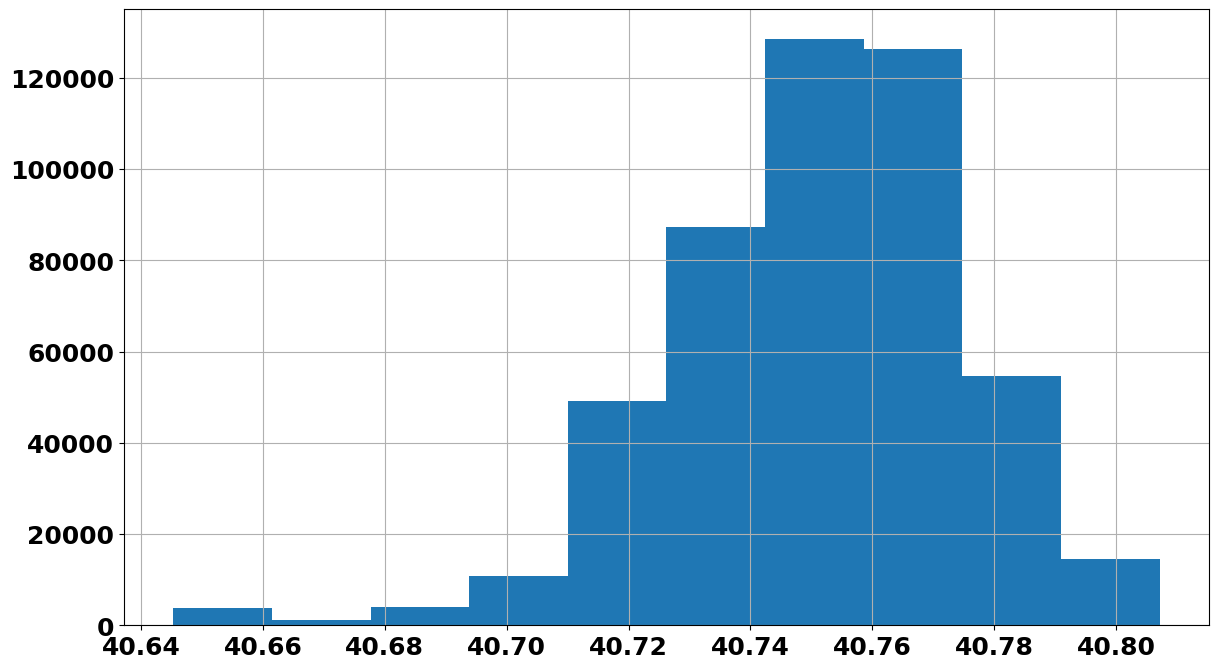

In [95]:
fulldf[(fulldf.longitude > fulldf.longitude.quantile(0.01)) & (fulldf.longitude < fulldf.longitude.quantile(0.99))].longitude
fulldf[(fulldf.latitude > fulldf.latitude.quantile(0.01)) & (fulldf.latitude < fulldf.latitude.quantile(0.99))].latitude.hist()